In [1]:
import ee

from IPython.display import Image

ee.Authenticate() #Usual authentication, so far. Nothing new


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
#Function to download images as a list - thanks Connor Finn. 
def get_images(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
  coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))
  image_ids = list(map(lambda x: x['id'], coll.getInfo()['features']))

  images = list(map(lambda x: ee.Image(x), image_ids))

  return images

In [5]:
'''
Functions needed to display images and features/featurecollections are given here. 
These functions are all from other sources. Mostly from google tutorials.
'''
!pip install geojson
!pip install pygeoj
import geojson
import json
import pygeoj
import numpy as np


import folium


# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [6]:
p = [144]
r = [48]
sat = 'LANDSAT/LC08/C01/T1'
sd = '2013-05-01'
ed = '2020-05-01'
cc= 5

image_list = get_images(p, r, sat, sd, ed, cc)

In [7]:
inputimg = image_list[0]

def addBandsToLandsat8_NDWI_NDVI_PixelLonLat(image):
  '''
  Function to add bands NDWI, NDVI, and PixelLonLat to a Landsat8 image
  '''
  ndwi = image.normalizedDifference(['B3', 'B6']).rename('ndwi')
  ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
  imgpixLonLat = image.pixelLonLat()

  image1 = image.addBands(ndwi).addBands(ndvi).addBands(imgpixLonLat)

  return image1

inputimgWithAddedBands = addBandsToLandsat8_NDWI_NDVI_PixelLonLat(inputimg)

In [8]:
roisite = ee.Geometry.Rectangle([77999/1000, 17135/1000, 78889/1000, 17701/1000]);

In [9]:
#training = inputimg.sample({'region': nycsite, 'scale': 30.0, 'numPixels': 5000});
bandToBeUsed = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'ndwi', 'ndvi']
training = inputimgWithAddedBands.select(bandToBeUsed).sample(region = roisite, scale = 30.0, numPixels = 5000); #Training is based on 500 randomly chosen pizels from within NYC area

In [10]:
numClusters = 3 #Number of clusters, I suspect. I think this should correspond to urban, non-urban, and water.
clusterer = ee.Clusterer.wekaKMeans(numClusters).train(training) #Not sure what wekaMeans is - just the code used in the GEE tutorial

In [11]:
result = inputimgWithAddedBands.cluster(clusterer); #Clustered result

In [13]:
my_map = folium.Map(location=[ 17.429, 78.483], zoom_start=9, height=500) #Adding result to folium map

my_map.add_ee_layer(result, {'min': 0, 'max': numClusters-1, 'palette': ['white', 'blue', 'green'], 'opacity':0.9}, 'clustering')
#my_map.add_ee_layer(inputimg.select(['B4','B3','B2']), {'min': 0, 'max': 30000, 'palette': [], 'opacity': 0.8}, 'image')
my_map.add_child(folium.LayerControl())

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

toBeHisted = result.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['cluster']).get('list').getInfo()[0]

(array([460.,  45., 475.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

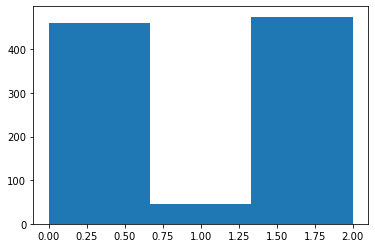

In [15]:
plt.hist(toBeHisted, bins = numClusters,  align='mid')

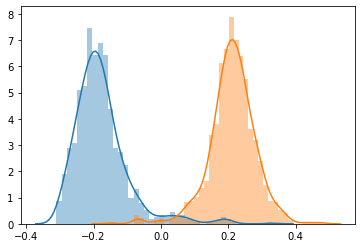

In [16]:
import seaborn as sns
sns.distplot(ee.List(inputimgWithAddedBands.select(['ndwi']).sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['ndwi']).get('list')).getInfo(),
             label='B3B6')
sns.distplot(ee.List(inputimgWithAddedBands.select(['ndvi']).sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['ndvi']).get('list')).getInfo(),label='B5B4')

In [17]:
waterRegion = inputimgWithAddedBands.select(['ndwi']).gt(0.05)
greenRegion = inputimgWithAddedBands.select(['ndvi']).gt(0.2)

In [18]:
parameters = {'min': 0,
              'max': 1.0,
              'dimensions': 600}
Image(url = waterRegion.select(['ndwi']).getThumbUrl(parameters))

#Image(url = greenRegion.select(['ndvi']).getThumbUrl(parameters))

In [19]:
my_map = folium.Map(location=[ 17.429, 78.483], zoom_start=9, height=500) #Adding result to folium map

my_map.add_ee_layer(result, {'min': 0, 'max': numClusters-1, 'palette': ['white', 'blue', 'green'], 'opacity':0.6}, 'clustering')
my_map.add_ee_layer(waterRegion.select(['ndwi']), {'min': 0, 'max': 1, 'palette': ['white', 'blue'], 'opacity':0.6}, 'ndwi')
my_map.add_ee_layer(greenRegion.select(['ndvi']), {'min': 0, 'max': 1, 'palette': ['white', 'green'], 'opacity':0.6}, 'ndvi')
my_map.add_child(folium.LayerControl())

In [20]:
import cv2 as cv2

In [21]:
import numpy as np

In [22]:
waterRegionWithLatLon = waterRegion.addBands(waterRegion.pixelLonLat())

ndwiImage = waterRegionWithLatLon.select(['ndwi'])
lats = waterRegionWithLatLon.select(['latitude'])
lons = waterRegionWithLatLon.select(['longitude'])

'''
ndwiImage = ndwiImage.reduceRegion(reducer   = ee.Reducer.toList(), 
                                   geometry  = roisite,
                                   maxPixels = 1e8, 
                                   scale     = 30)

lats = lats.reduceRegion(reducer   = ee.Reducer.toList(), 
                                   geometry  = roisite,
                                   maxPixels = 1e8, 
                                   scale     = 30)

lons = lons.reduceRegion(reducer   = ee.Reducer.toList(), 
                                   geometry  = roisite, 
                                   maxPixels = 1e8, 
                                   scale     = 30)
'''

waterRegionWithLatLon = waterRegionWithLatLon.reduceRegion(reducer   = ee.Reducer.toList(), 
                                   geometry  = roisite, 
                                   #maxPixels = 3e8,
                                   bestEffort = True, 
                                   scale     = 30)

In [ ]:
#ndwi_values = np.array(ee.Array(ndwiImage.get('ndwi')).getInfo()) #By using a different source for ndvi, lats, and lons, ndwi length is different from lats and lons

In [ ]:
#lats_values = np.array(ee.Array(lats.get('latitude')).getInfo()) #By using a different source for ndvi, lats, and lons, ndwi length is different from lats and lons

In [ ]:
#lons_values = np.array(ee.Array(lons.get('longitude')).getInfo()) #By using a different source for ndvi, lats, and lons, ndwi length is different from lats and lons

In [24]:
#waterRegionWithLatLon = waterRegion.addBands(waterRegion.pixelLonLat())
##By using a different source for ndvi, lats, and lons, ndwi length is different from lats and lons. Here, I am using the same source.
ndwi_values = np.array(ee.Array(waterRegionWithLatLon.get('ndwi')).getInfo())
lats_values = np.array(ee.Array(waterRegionWithLatLon.get('latitude')).getInfo())
lons_values = np.array(ee.Array(waterRegionWithLatLon.get('longitude')).getInfo())

In [128]:
import pandas as pd

dicts = {'ndwi': ndwi_values, 'latitude': lats_values, 'longitude': lons_values}

ndwi_df = pd.DataFrame(dicts)

In [129]:
print(len(ndwi_values), len(lats_values), len(lons_values)) #When I use the same source, I get list of equal length

3333461 3333461 3333461


In [28]:
lats_values_unique = np.unique(lats_values)

In [31]:
type(lats_values)

numpy.ndarray

In [130]:
picker = np.random.randint(low=0, high=3333461, size=40000)

In [131]:
ndwivals_rand = ndwi_values[picker]

In [132]:
lats_rand = lats_values[picker]

In [133]:
lons_rand = lons_values[picker]

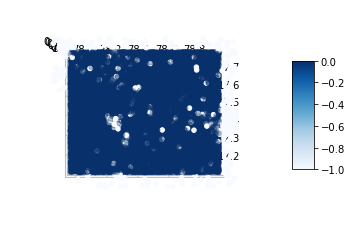

In [134]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

f = plt.figure()
ax1 = plt.axes(projection="3d")

#x, y = np.meshgrid(lons_rand, lats_rand)

my_cmap = plt.get_cmap('Blues')

#scat = ax1.scatter3D(lats_rand, lons_rand, -ndwivals_rand, c=-ndwivals_rand, cmap=my_cmap, alpha=0.6)
scat = ax1.scatter3D(lats_rand, lons_rand, -ndwivals_rand, c=-ndwivals_rand, cmap=my_cmap)
ax1.view_init(elev=-90, azim=0)
ax1.set_zlim([0.4,1])

f.colorbar(scat, ax = ax1, shrink = 0.5, aspect = 5)

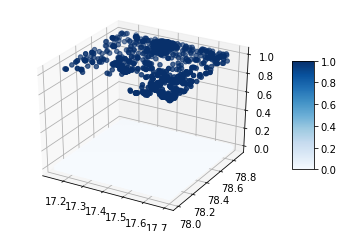

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

f = plt.figure()
ax1 = plt.axes(projection="3d")

#x, y = np.meshgrid(lons_rand, lats_rand)

my_cmap = plt.get_cmap('Blues')

#scat = ax1.scatter3D(lats_rand, lons_rand, -ndwivals_rand, c=-ndwivals_rand, cmap=my_cmap, alpha=0.6)
scat = ax1.scatter3D(lats_rand, lons_rand, ndwivals_rand, c=ndwivals_rand, cmap=my_cmap)


f.colorbar(scat, ax = ax1, shrink = 0.5, aspect = 5)

In [196]:
exportROI = roisite

from ee import batch

#outputImage = results.map(lambda x: x.multiply(512).uint8())

task = ee.batch.Export.image.toDrive(image = result, description = 'clusteredHyd', 
                                     scale = 30, 
                                     region = exportROI.getInfo()['coordinates'],
                                     crs = inputimg.select(['B1']).projection().getInfo()['crs'])

task.start()

#batch.Task.start(task)

In [172]:
!pip install rasterio

     |████████████████████████████████| 18.2 MB 2.4 MB/s eta 0:00:01    |████████████████▍               | 9.3 MB 1.9 MB/s eta 0:00:05
     |████████████████████████████████| 82 kB 328 kB/s eta 0:00:01


In [167]:
import skimage
from skimage import io

In [187]:
inputimg.get('MAP_PROJECTION').getInfo()

'UTM'

In [188]:
inputimg.propertyNames().getInfo()

['RADIANCE_MULT_BAND_5',
 'RADIANCE_MULT_BAND_6',
 'RADIANCE_MULT_BAND_3',
 'RADIANCE_MULT_BAND_4',
 'RADIANCE_MULT_BAND_1',
 'RADIANCE_MULT_BAND_2',
 'system:id',
 'K2_CONSTANT_BAND_11',
 'K2_CONSTANT_BAND_10',
 'system:footprint',
 'REFLECTIVE_SAMPLES',
 'SUN_AZIMUTH',
 'CPF_NAME',
 'DATE_ACQUIRED',
 'ELLIPSOID',
 'google:registration_offset_x',
 'google:registration_offset_y',
 'STATION_ID',
 'RESAMPLING_OPTION',
 'ORIENTATION',
 'WRS_ROW',
 'RADIANCE_MULT_BAND_9',
 'TARGET_WRS_ROW',
 'RADIANCE_MULT_BAND_7',
 'RADIANCE_MULT_BAND_8',
 'IMAGE_QUALITY_TIRS',
 'TRUNCATION_OLI',
 'CLOUD_COVER',
 'GEOMETRIC_RMSE_VERIFY',
 'COLLECTION_CATEGORY',
 'GRID_CELL_SIZE_REFLECTIVE',
 'CLOUD_COVER_LAND',
 'GEOMETRIC_RMSE_MODEL',
 'COLLECTION_NUMBER',
 'IMAGE_QUALITY_OLI',
 'LANDSAT_SCENE_ID',
 'WRS_PATH',
 'google:registration_count',
 'PANCHROMATIC_SAMPLES',
 'PANCHROMATIC_LINES',
 'GEOMETRIC_RMSE_MODEL_Y',
 'REFLECTIVE_LINES',
 'TIRS_STRAY_LIGHT_CORRECTION_SOURCE',
 'GEOMETRIC_RMSE_MODEL_X',
 'sy

In [270]:
inputimg.select(['B1']).projection().getInfo()['crs']

'EPSG:32644'

In [202]:
parameters = {'min': 0,
              'max': 2,
              'dimensions': 600,
            'palette': ['white', 'blue', 'green']}
Image(url = result.select(['cluster']).clip(roisite).getThumbUrl(parameters))

In [211]:
parameters = {'min': 0,
              'max': 1,
              'dimensions': 600,
            'palette': ['white', 'blue']}
Image(url = waterRegion.select(['ndwi']).clip(roisite).getThumbUrl(parameters))

In [212]:
parameters = {'min': -1,
              'max': 1,
              'dimensions': 600,
            'palette': ['black','white', 'green']}
Image(url = greenRegion.select(['ndvi']).clip(roisite).getThumbUrl(parameters))

In [222]:
jsonfilepath = '/home/arvindn/Research/TopicsOfInterest/Agriculture/Notes/AlmostCircleAroundHyderabad.json'
with open(jsonfilepath) as f:
    data = geojson.load(f)

coords = np.array(data['features'][0]['geometry']['coordinates'][0])[:,0:2].tolist()

eeGeom = ee.Geometry.Polygon(coords)

eeFeat = ee.Feature(eeGeom)

parameters = {'min': 0,
              'max': 1,
              'dimensions': 600,
            'palette': ['white', 'blue']}
Image(url = waterRegion.select(['ndwi']).clip(eeGeom).getThumbUrl(parameters))

In [234]:
import openstreetmap

In [238]:
from openstreetmap import Crawler
c = Crawler()
boundary = c.name_parse('Hyderabad', level='city',coo_order=True)
# level: country state city county town
# coo_order  :False ->lng,lat ; True -> lat,lng  coo_order;
print(boundary.info)
boundary = c.id_parse("2458199", csys='wgs84', coo_order=True)
# csys(Coordinate System): wgs84 gcj02 bd09
print(boundary.info)

ImportError: cannot import name 'Crawler' from 'openstreetmap' (unknown location)

(554934.3850048161, 567962.5804682304, 4187387.8146945997, 4196109.8448516065)

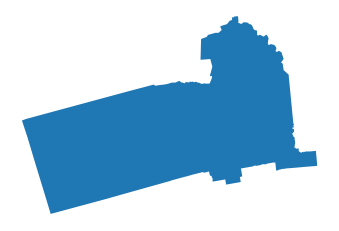

In [252]:
import osmnx as ox
city = ox.geocode_to_gdf('Berkeley, California')
ax = ox.project_gdf(city).plot()
ax.axis('off')

(-42856.26054304761, 453152.6011296198, 864174.701404518, 1529714.76672013)

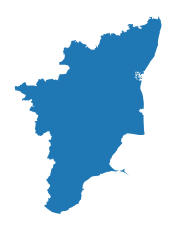

In [256]:
state = ox.geocode_to_gdf('Tamil Nadu, India')
ax1 = ox.project_gdf(state).plot()
ax1.axis('off')

(579920.6603684197, 592751.4050458955, 4503033.8907299135, 4527153.442921117)

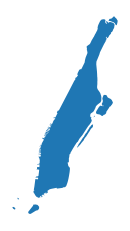

In [258]:
cityManhattan = ox.geocode_to_gdf('Manhattan, New York')
ax = ox.project_gdf(cityManhattan).plot()
ax.axis('off')

In [261]:
cityManhattan

/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0    0.006415
dtype: float64

In [268]:
jsonfilepath = '/home/arvindn/Research/TopicsOfInterest/Agriculture/Notes/AlmostCircleAroundHyderabad.json'
with open(jsonfilepath) as f:
    data = geojson.load(f)

coords = np.array(data['features'][0]['geometry']['coordinates'][0])[:,0:2].tolist()

eeGeom = ee.Geometry.Polygon(coords)

eeFeat = ee.Feature(eeGeom)

parameters = {'min': 0,
              'max': 1,
              'dimensions': 600,
            'palette': ['white', 'blue']}
waterRegion.select(['ndwi']).clip(eeGeom).getThumbURL(parameters)

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc6e357188289f12d3419b342fbc2226-c09eb313ca30c14ddc139ef29d24b467:getPixels'

In [271]:
parameters = {'min': 0,
              'max': 1,
              'scale': 30,
            'palette': ['white', 'blue'],
             'crs': inputimg.select(['B1']).projection().getInfo()['crs']}
waterRegion.select(['ndwi']).clip(eeGeom).getDownloadURL(parameters)

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/33d959e940d64a438f90d2512be14f83-cb829e233eb1d6b97161098cd1286311:getPixels'

In [309]:
import cv2 as cv2
import numpy as np

from skimage import io

In [310]:
waterHyd = io.imread('./waterBodiesInAndAroundHyd.tif')

In [311]:
waterHyd.shape

(2930, 2880)

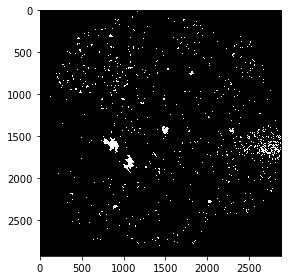

In [275]:
ret,thresh = cv2.threshold(waterHyd,75,255,0) #thresholding, this time using
                                            #OpenCV

io.imshow(thresh) #showing the image using skimage.io

In [312]:
#Drawing contours - not sure how openCV does it.
contours, hierarchy = cv2.findContours(thresh, 
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_SIMPLE)

area:  48.0 centroid:  (1256, 2821) perimeter:  42.62741661071777
area:  94.5 centroid:  (1426, 2805) perimeter:  51.55634891986847
area:  37.5 centroid:  (1168, 2778) perimeter:  33.21320307254791
area:  31.5 centroid:  (983, 2775) perimeter:  31.55634891986847
area:  364.0 centroid:  (1826, 2777) perimeter:  112.08326005935669
area:  19.5 centroid:  (1637, 2771) perimeter:  21.899494767189026
area:  123.0 centroid:  (1238, 2772) perimeter:  54.14213538169861
area:  32.0 centroid:  (1712, 2762) perimeter:  32.97056245803833
area:  32.5 centroid:  (1601, 2758) perimeter:  44.041630029678345
area:  59.5 centroid:  (1837, 2761) perimeter:  67.84061932563782
area:  133.5 centroid:  (686, 2742) perimeter:  76.52691125869751
area:  75.0 centroid:  (1341, 2715) perimeter:  53.79898953437805
area:  288.0 centroid:  (1406, 2715) perimeter:  99.59797883033752
area:  46.5 centroid:  (1064, 2702) perimeter:  47.21320307254791
area:  52.0 centroid:  (1799, 2700) perimeter:  40.627416253089905
area

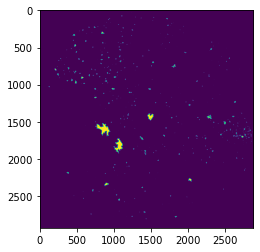

In [282]:
f, ax1 = plt.subplots(1)

frame = thresh
for i, contour in enumerate(contours):
    c_area = cv2.contourArea(contour)
    c_perimeter = cv2.arcLength(contour, True)
    if (c_area > 16):
        moments_cnt = cv2.moments(contour)
        cx = int(moments_cnt['m10']/moments_cnt['m00'])
        cy = int(moments_cnt['m01']/moments_cnt['m00'])
        print("area: ", c_area, "centroid: ", (cx, cy), "perimeter: ", c_perimeter)
        #ax1.plot(cx, cy, 'o')
        frame = cv2.drawContours(frame, contour, -1, (0, 255, 0), 2)


frameWithContours = cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)

#ax1.imshow(frameWithContours)
ax1.imshow(frame)

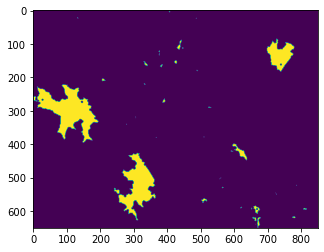

In [287]:
plt.imshow(frame[1300:1950,750:1600])

In [284]:
frame.shape

(2930, 2880)

In [306]:
contoursArea = map(cv2.contourArea, contours)
contoursAreaNumpy = np.sort(list(contoursArea))
np.sort(contoursAreaNumpy)[-5:]*900/1e6 #area in km^2

array([ 1.69515,  2.40615,  4.30425, 10.14075, 13.69485])

In [305]:
4782.5*900

4304250.0